⛱️ [SANDBOX] Opening serial connection: port=/dev/ttyACM0, baudrate=115200, timeout=1.0s
⛱️ [SANDBOX] Serial TX (/dev/ttyACM0): '*IDN?'
⛱️ [SANDBOX] Serial RX (/dev/ttyACM0): 'XPOW'
⛱️ [SANDBOX] Serial TX (/dev/ttyACM0): 'CH:17:CUR:65535'
⛱️ [SANDBOX] Serial TX (/dev/ttyACM0): 'CH:17:VOLT:1638'
⛱️ [SANDBOX] Serial TX (/dev/ttyACM0): 'CH:17:VAL?'
⛱️ [SANDBOX] Serial RX (/dev/ttyACM0): 'CH:17:VAL?  >>  Channel 17 = 0.996V, 297.780mA'
⛱️ [SANDBOX] Serial TX (/dev/ttyACM0): 'CH:17:VAL?'
⛱️ [SANDBOX] Serial RX (/dev/ttyACM0): 'CH:17:VAL?  >>  Channel 17 = 0.996V, 297.780mA'
⛱️ [SANDBOX] Serial TX (/dev/ttyACM0): 'CH:17:VOLT:49151'
⛱️ [SANDBOX] Serial TX (/dev/ttyACM0): 'CH:17:VAL?'
⛱️ [SANDBOX] Serial RX (/dev/ttyACM0): 'CH:17:VAL?  >>  Channel 17 = 29.893V, 297.780mA'
⛱️ [SANDBOX] Serial TX (/dev/ttyACM0): 'CH:17:VAL?'
⛱️ [SANDBOX] Serial RX (/dev/ttyACM0): 'CH:17:VAL?  >>  Channel 17 = 29.893V, 297.780mA'
⛱️ [SANDBOX] Serial TX (/dev/ttyACM0): 'CH:17:CUR:0'
⛱️ [SANDBOX] Serial TX (/dev/tt

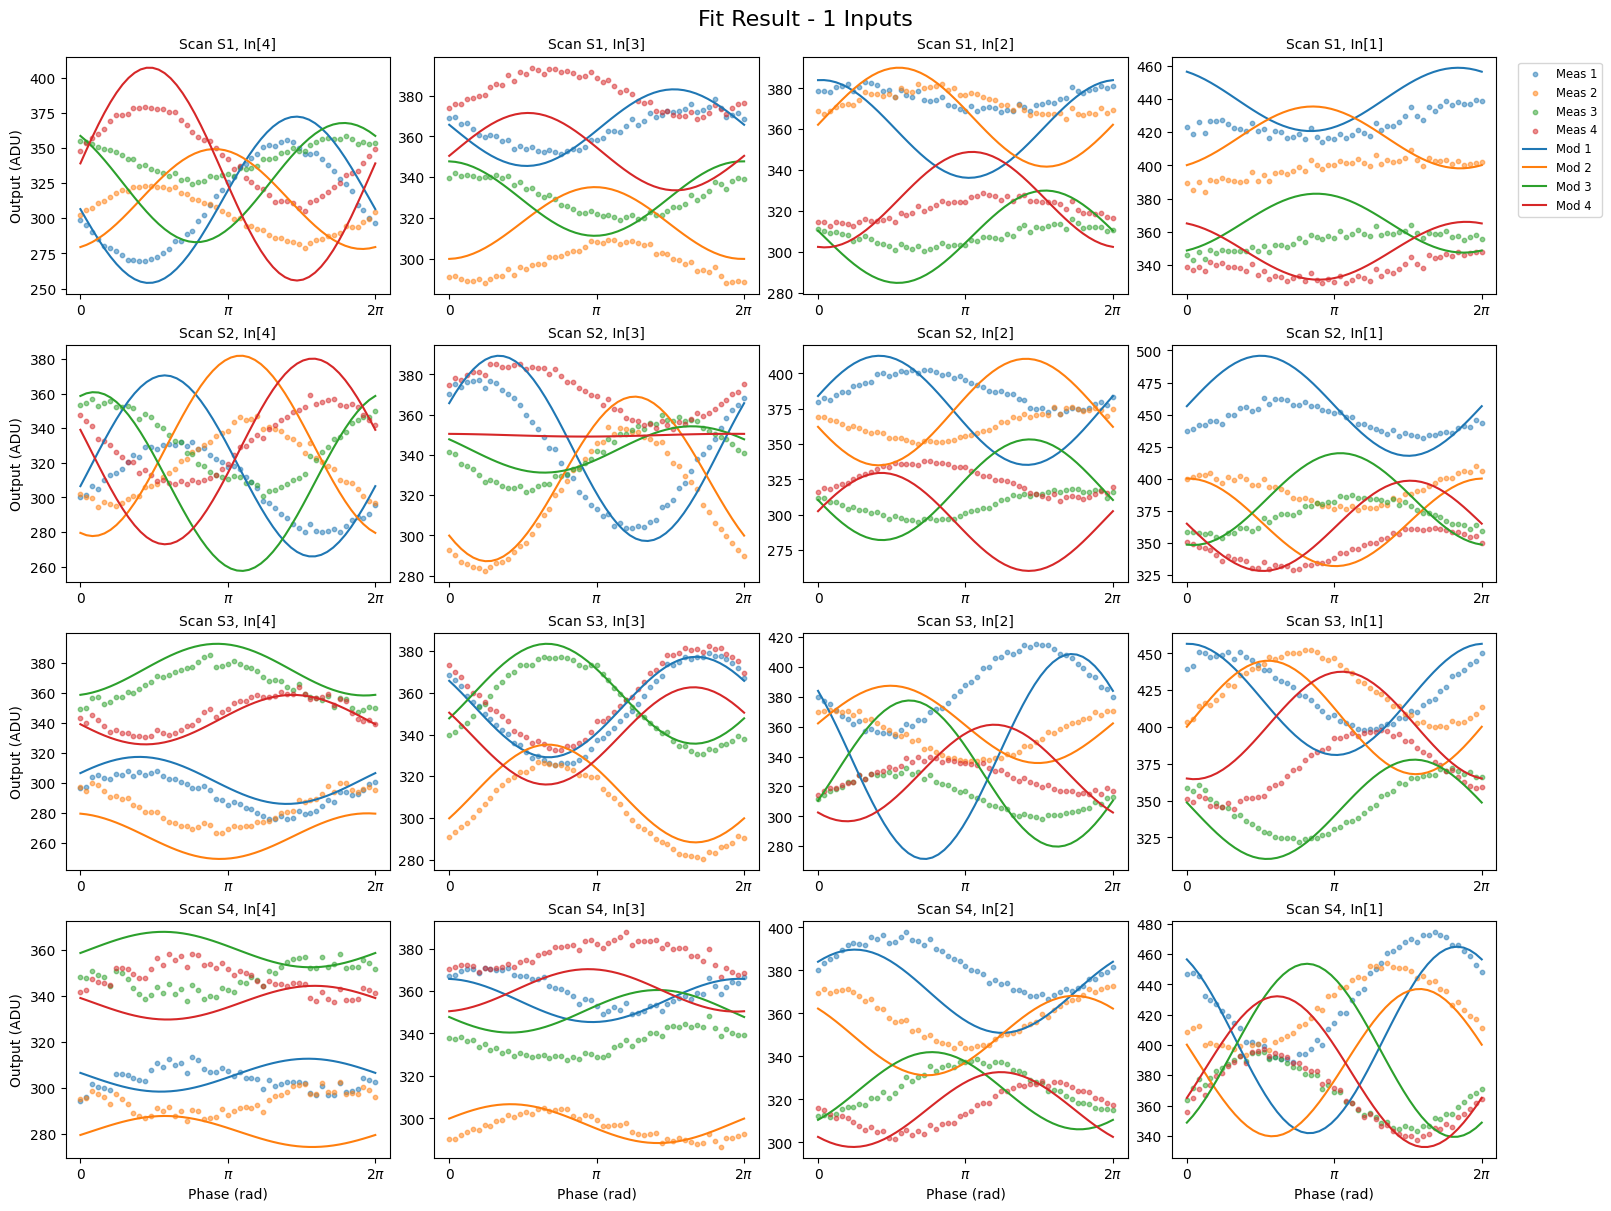

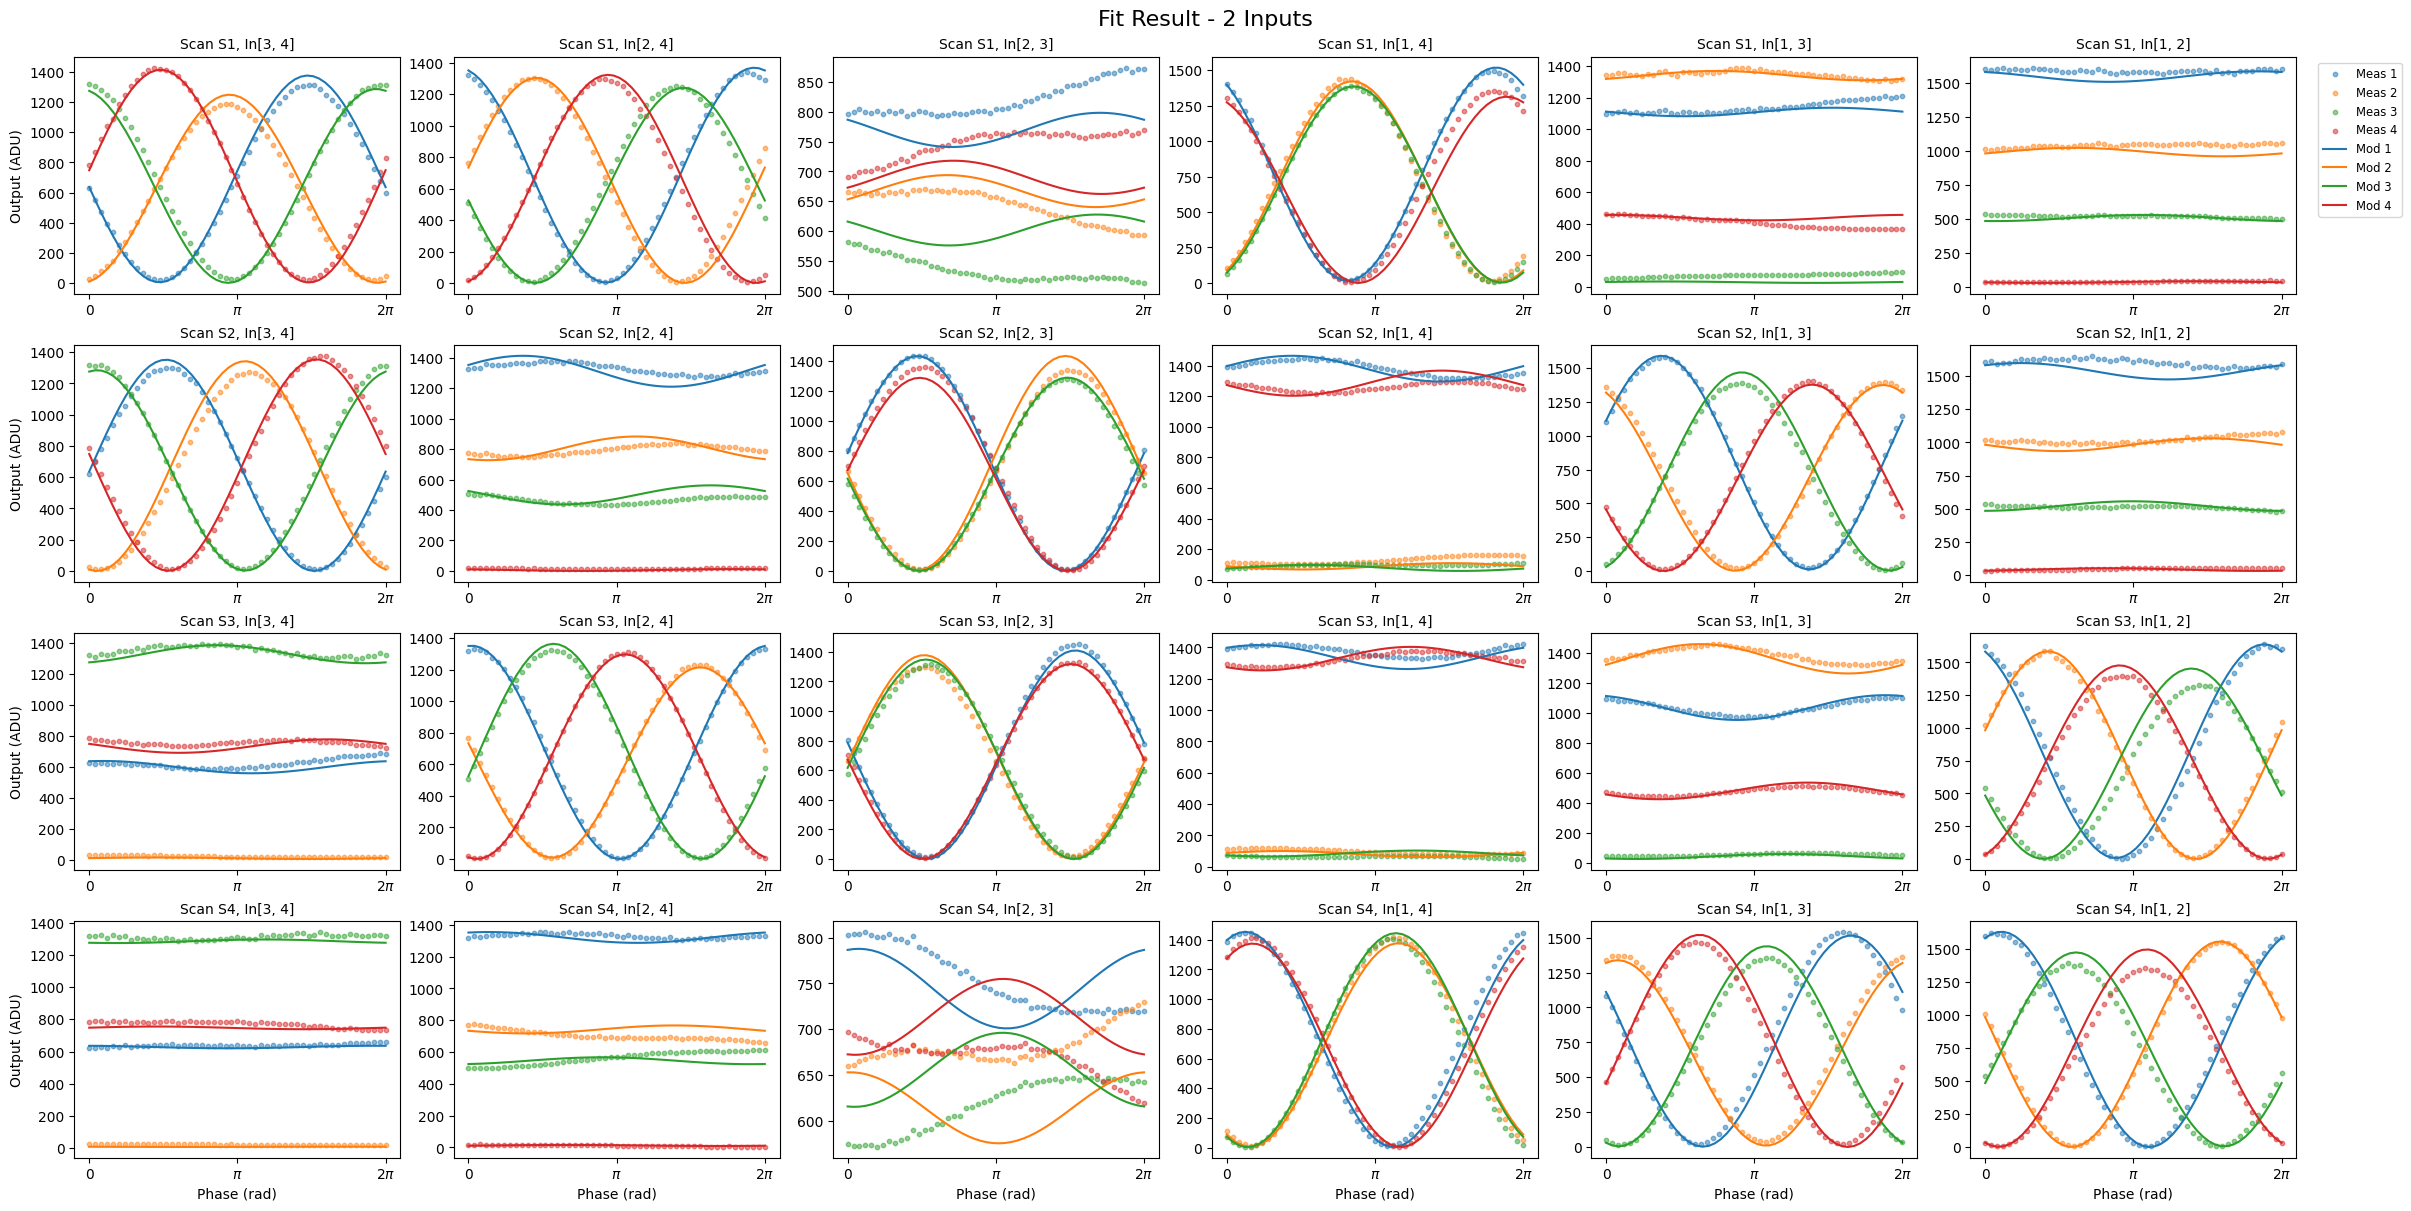

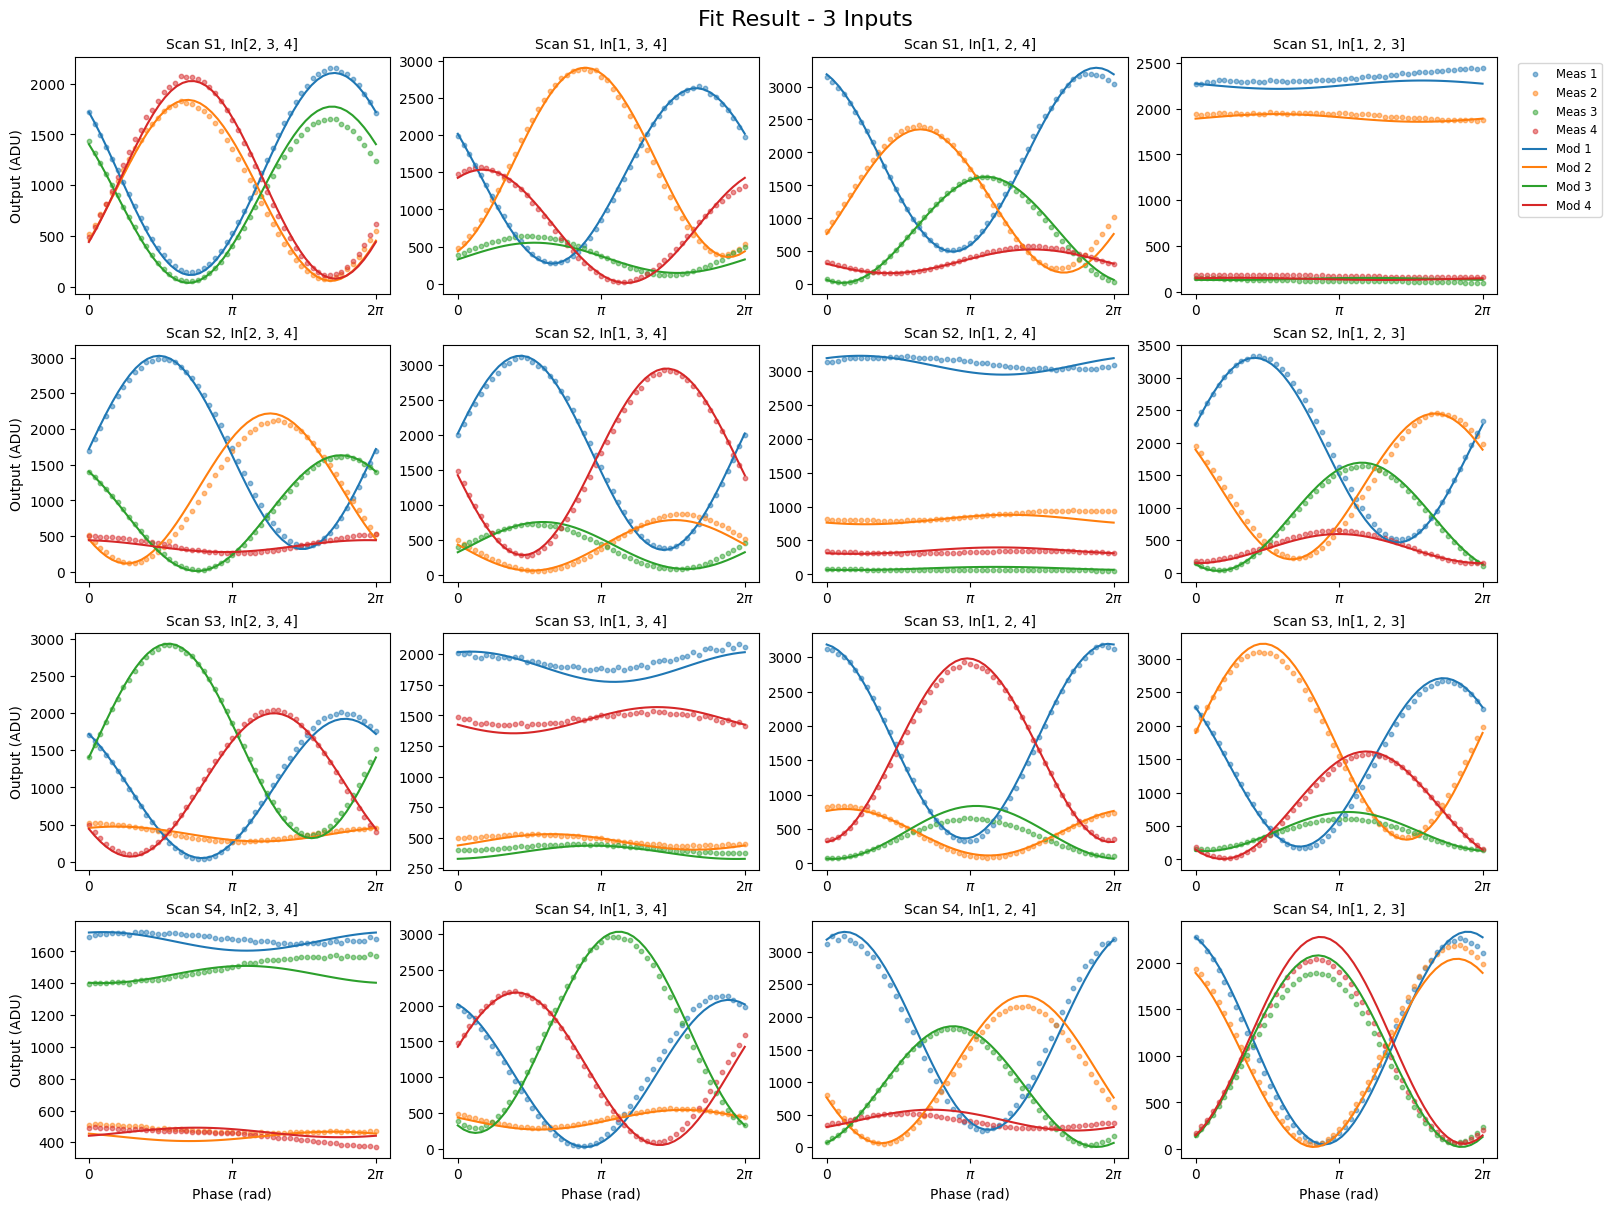

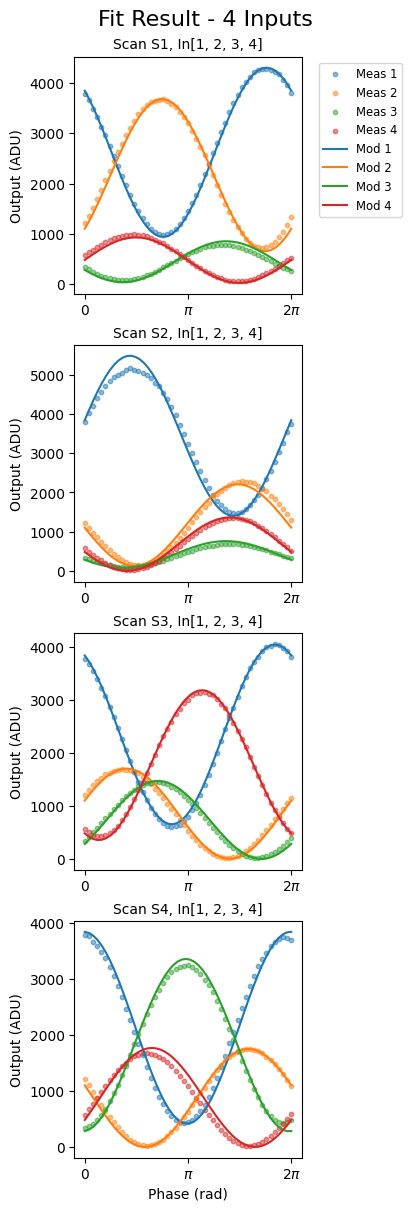

In [1]:
import phobos

arch = phobos.Arch6()

outs = arch.solve_matrix(data_path='./generated/architecture_characterization/4-Port_MMI_Active/20251208_164250/characterization_data.npz')

In [2]:
from IPython.display import display, Math
import numpy as np

def format_complex(val):
    alpha = np.abs(val)
    if alpha < 1e-10:
        return "0"
    beta = np.angle(val) / np.pi
    return f"{alpha:.2f}e^{{i({beta:.2f})\\pi}}"

def display_results(data, label=None):
    if label:
        print(label)
        
    # Standardize to 2D for loop
    if data.ndim == 1:
        matrix = data.reshape(1, -1) # Display as row vector
    else:
        matrix = data

    latex_rows = []
    for row in matrix:
        formatted_elements = [format_complex(val) for val in row]
        latex_rows.append(" & ".join(formatted_elements))

    latex_str = r"\begin{pmatrix} " + r" \\ ".join(latex_rows) + r" \end{pmatrix}"
    display(Math(latex_str))

    # Norm Check
    if data.ndim == 2: # Matrix
        norm = np.linalg.norm(data, 2)
        print(f"Spectral Norm: {norm:.4f}")
        if norm <= 1.001:
             print("Energy conservation check: Pass (<= 1)")
        else:
             print("Energy conservation check: Fail (> 1)")
    elif data.ndim == 1: # Vector
        norm = np.linalg.norm(data)
        print(f"L2 Norm: {norm:.4f}")
    print("-"*30)

# Display Results
if 'cost' in outs:
    print(f"Optimization Cost: {outs['cost']:.4e}\n")

vectors = ['I_ON', 'I_OFF']
for key in vectors:
    if key in outs:
        display_results(outs[key], label=f"{key} (Control Vector):")

matrices = ['A', 'C_before']
for key in matrices:
    if key in outs:
        display_results(outs[key], label=f"Matrix {key}:")


Optimization Cost: 2.9382e+05

I_ON (Control Vector):


<IPython.core.display.Math object>

L2 Norm: 77.9210
------------------------------
I_OFF (Control Vector):


<IPython.core.display.Math object>

L2 Norm: 3.1080
------------------------------
Matrix A:


<IPython.core.display.Math object>

Spectral Norm: 1.0000
Energy conservation check: Pass (<= 1)
------------------------------
Matrix C_before:


<IPython.core.display.Math object>

Spectral Norm: 1.0000
Energy conservation check: Pass (<= 1)
------------------------------


In [9]:

import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display

# Retrieve A from previous results
A_rec = outs['A']

def plot_phasors(phi1, phi2, phi3, phi4):
    # Phases in radians
    phases = np.array([phi1, phi2, phi3, phi4])
    
    # Input vector v = P @ [1, 1, 1, 1] = [exp(1j*phi1), ...]
    v = np.exp(1j * phases * np.pi)
    
    # Create Figure
    fig, axs = plt.subplots(1, 4, subplot_kw={'projection': 'polar'}, figsize=(20, 5))
    fig.suptitle('Phasor Contributions per Output (Interactive Phases)', fontsize=16, y=1.1)

    labels = ['In 1', 'In 2', 'In 3', 'In 4']
    colors = ['red', 'green', 'blue', 'orange']

    for k in range(4): # Output k
        ax = axs[k]
        ax.set_title(f"Output {k+1}", va='bottom')
        
        resultant = 0
        
        for j in range(4): # Input j
            # Contribution: A_kj * v_j
            val = A_rec[k, j] * v[j]
            resultant += val
            
            theta = np.angle(val)
            r = np.abs(val)
            
            # Plot individual contribution vector
            ax.plot([0, theta], [0, r], color=colors[j], label=labels[j] if k==0 else "", alpha=0.7, linewidth=1.5)
            ax.plot([theta], [r], 'o', color=colors[j], markersize=5)

        # Plot Resultant Vector
        theta_res = np.angle(resultant)
        r_res = np.abs(resultant)
        ax.plot([0, theta_res], [0, r_res], color='black', linewidth=2.5, linestyle='-', label='Sum' if k==0 else "")
        
        # Fixed scale for stability
        ax.set_ylim(0, 1.5)
        ax.grid(True)

    # Standard Legend
    fig.legend(loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.1))
    plt.tight_layout()
    plt.show()

# Widgets
style = {'description_width': 'initial'}
sliders = [
    widgets.FloatSlider(min=0, max=2, step=0.01, value=0, description=f'Phase {i+1} (rad)', style=style, layout=widgets.Layout(width='300px')) 
    for i in range(4)
]

ui = widgets.VBox(sliders)
out_plot = widgets.interactive_output(plot_phasors, {'phi1': sliders[0], 'phi2': sliders[1], 'phi3': sliders[2], 'phi4': sliders[3]})

display(ui, out_plot)



Output()